In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Loading data
stock_prices_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/faang_stocks.csv', index_col="Date")

# Changing the index to a datetime type allows for easier filtering and plotting.
stock_prices_df.index = pd.to_datetime(stock_prices_df.index)
stock_prices_df.head(5)

,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2020-01-02,75.09,94.90,68.43,209.78,329.81
2020-01-03,74.36,93.75,68.08,208.67,325.90
2020-01-06,74.95,95.14,69.89,212.60,335.83
2020-01-07,74.60,95.34,69.76,213.06,330.75
2020-01-08,75.80,94.60,70.25,215.22,339.26


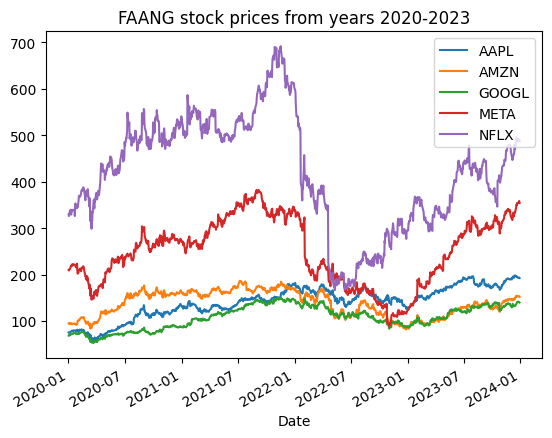

In [20]:
# Plotting the stock prices
stock_prices_df.plot(title="FAANG stock prices from years 2020-2023");

In [24]:
rf = 0
benchmark_weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

returns = stock_prices_df.pct_change().dropna()
portfolio_returns = returns.dot(benchmark_weights)
benchmark_exp_return = portfolio_returns.mean()*252
benchmark_std = portfolio_returns.std()*np.sqrt(252)

benchmark_sharpe_ratio = (benchmark_exp_return - rf)/benchmark_std
print([benchmark_exp_return, benchmark_sharpe_ratio])

[np.float64(0.23604765737238026), np.float64(0.7221868020795006)]


In [25]:
mu = expected_returns.mean_historical_return(stock_prices_df,frequency=252, compounding=True, log_returns=False)
Sigma = risk_models.sample_cov(stock_prices_df, frequency=252, compounding=True, log_returns=False)
ef = EfficientFrontier(mu, Sigma)
mv_raw_weights = ef.min_volatility()
mv_portfolio = ef.clean_weights()
_, mv_portfolio_vol, _ = ef.portfolio_performance(verbose=True, risk_free_rate = rf)
mv_portfolio = pd.Series(mv_portfolio)
print(mv_portfolio)
print(mv_portfolio_vol)

Expected annual return: 20.7%
Annual volatility: 30.3%
Sharpe Ratio: 0.68
AAPL     0.39842
AMZN     0.14911
GOOGL    0.38290
META     0.00000
NFLX     0.06957
dtype: float64
0.30307367115474637


In [26]:
mu = expected_returns.mean_historical_return(stock_prices_df,frequency=252, compounding=True, log_returns=False)
Sigma = risk_models.sample_cov(stock_prices_df, frequency=252, compounding=True, log_returns=False)
ef = EfficientFrontier(mu, Sigma)
ms_raw_weights = ef.max_sharpe(risk_free_rate = rf)
ms_portfolio = ef.clean_weights()
ms_portfolio = pd.Series(ms_portfolio)
_, _, ms_portfolio_sharpe = ef.portfolio_performance(risk_free_rate = rf)
print(ms_portfolio)
print(ms_portfolio_sharpe)

AAPL     0.91479
AMZN     0.00000
GOOGL    0.08521
META     0.00000
NFLX     0.00000
dtype: float64
0.7948717093574752


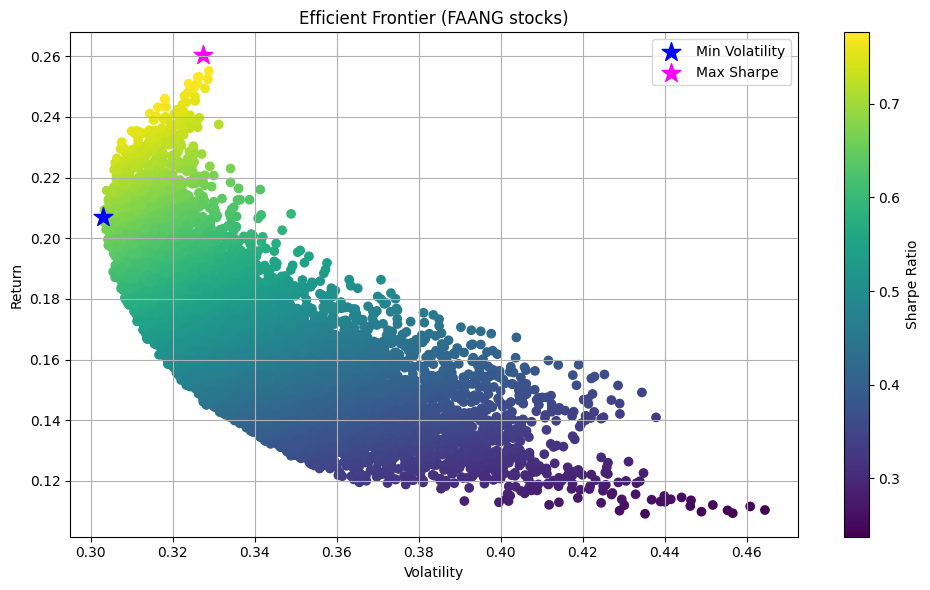

In [28]:
n_portfolios = 10000
results = np.zeros((3, n_portfolios))
weights_record = []

for i in range(n_portfolios):
    weights = np.random.dirichlet(np.ones(len(stock_prices_df.columns)))
    weights_record.append(weights)
    port_return = np.dot(weights, mu)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    sharpe_ratio = port_return / port_volatility
    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe_ratio

# 找最优组合点
ef = EfficientFrontier(mu, Sigma)
min_vol_weights = ef.min_volatility()
ret_minvol, std_minvol, _ = ef.portfolio_performance()
ef = EfficientFrontier(mu, Sigma)
max_sharpe_weights = ef.max_sharpe()
ret_maxsharpe, std_maxsharpe, _ = ef.portfolio_performance()

# 画图
plt.figure(figsize=(10, 6))
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap="viridis")
plt.colorbar(scatter, label="Sharpe Ratio")
plt.scatter(std_minvol, ret_minvol, color='blue', marker='*', s=200, label="Min Volatility")
plt.scatter(std_maxsharpe, ret_maxsharpe, color='magenta', marker='*', s=200, label="Max Sharpe")
plt.title("Efficient Frontier (FAANG stocks)")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()